In [2]:
#second stage of calculations. Combine WSA estimates from CLARA into EASE2 projection and calculate baselines.

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyresample
import dask.array as da
import pandas as pd
import glob

datadriveletter = 'Z:'
prod_data_dir = datadriveletter + '/radiative_forcing_2020/production_data/'
startyear = 1982
stopyear = 2018

In [3]:
WSA_VEG_NH = xr.open_dataarray(prod_data_dir + 'WSA_VEG_NH_full_extended.nc').sel(time=slice(str(startyear), str(stopyear)))
WSA_VEG_SH = xr.open_dataarray(prod_data_dir + 'WSA_VEG_SH_full_extended.nc').sel(time=slice(str(startyear), str(stopyear)))

WSA_SNOW_NH = xr.open_dataarray(prod_data_dir + 'WSA_SNOW_NH_full_extended.nc').sel(time=slice(str(startyear), str(stopyear)))
WSA_SNOW_SH = xr.open_dataarray(prod_data_dir + 'WSA_SNOW_SH_full_extended.nc').sel(time=slice(str(startyear), str(stopyear)))

WSA_SNOWFOREST_NH = xr.open_dataarray(prod_data_dir + 'WSA_SNOWFOREST_NH_full_extended.nc').sel(time=slice(str(startyear), str(stopyear)))
WSA_SNOWFOREST_SH = xr.open_dataarray(prod_data_dir + 'WSA_SNOWFOREST_SH_full_extended.nc').sel(time=slice(str(startyear), str(stopyear)))

In [4]:
OSA_NH = xr.open_dataarray(prod_data_dir + 'OSA_EASE2_NH_1979_2019_gapfilled.nc').sel(time=slice(str(startyear), str(stopyear)))
OSA_SH = xr.open_dataarray(prod_data_dir + 'OSA_EASE2_SH_1979_2019_gapfilled.nc').sel(time=slice(str(startyear), str(stopyear)))

In [5]:
#prefilter physically impossible values / loads into memory now, be aware
WSA_VEG_NH = xr.where(WSA_VEG_NH<1.0, WSA_VEG_NH, np.nan)
WSA_VEG_NH = xr.where(WSA_VEG_NH>0.0, WSA_VEG_NH, np.nan)
WSA_VEG_SH = xr.where(WSA_VEG_SH<1.0, WSA_VEG_SH, np.nan)
WSA_VEG_SH = xr.where(WSA_VEG_SH>0.0, WSA_VEG_SH, np.nan)

WSA_SNOW_NH = xr.where(WSA_SNOW_NH<1.0, WSA_SNOW_NH, np.nan)
WSA_SNOW_NH = xr.where(WSA_SNOW_NH>0.0, WSA_SNOW_NH, np.nan)
WSA_SNOW_SH = xr.where(WSA_SNOW_SH<1.0, WSA_SNOW_SH, np.nan)
WSA_SNOW_SH = xr.where(WSA_SNOW_SH>0.0, WSA_SNOW_SH, np.nan)

WSA_SNOWFOREST_NH = xr.where(WSA_SNOWFOREST_NH<1.0, WSA_SNOWFOREST_NH, np.nan)
WSA_SNOWFOREST_NH = xr.where(WSA_SNOWFOREST_NH>0.0, WSA_SNOWFOREST_NH, np.nan)
WSA_SNOWFOREST_SH = xr.where(WSA_SNOWFOREST_SH<1.0, WSA_SNOWFOREST_SH, np.nan)
WSA_SNOWFOREST_SH = xr.where(WSA_SNOWFOREST_SH>0.0, WSA_SNOWFOREST_SH, np.nan)

## NH, with seasonal snow

In [14]:
forestcover = xr.open_dataarray(datadriveletter + '/EASE2_reprojected/forestcover_MM_EASE2_1992_2018_ESACCI.nc')

In [16]:
forestcover_ext = forestcover.reindex({'time':WSA_VEG_NH.time}, method='bfill')

In [21]:
#NH snow cover from NSIDC0046. See below for SH treatment (no seasonal snow)
snowcover = xr.open_dataarray(prod_data_dir + 'NSIDC0046_snowicecover_MM_at_EASE2NH_1982_2018.nc')
snowcover = snowcover.transpose('time','lat','lon')


C:\Users\riihelaa\AppData\Local\Continuum\anaconda3\envs\scientia\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [35]:
#snow and sea ice cover treated as month-majority classification of 1,2,3, or 5.
#snow_ice_classes = [1,2,3,5]
WSA_EASE2_all = xr.where((snowcover==1) | (snowcover==2) | (snowcover==3) | (snowcover==5), \
                              WSA_SNOW_NH, WSA_VEG_NH)

In [36]:
#to classify as a snowy forest, forest fraction cover must be >0.25, must be snow covered, and dark enough
WSA_EASE2_all = xr.where((forestcover_ext>0.25) & ((snowcover==1) | (snowcover==5)) & \
                                                      (WSA_SNOW_NH<0.5), WSA_SNOWFOREST_NH, WSA_EASE2_all)

In [133]:
WSA_EASE2_all = xr.where(WSA_EASE2_all>0.0, WSA_EASE2_all, np.nan)

#open water from OSA estimates
WSA_EASE2_all = xr.where(snowcover<7, WSA_EASE2_all, OSA_NH)

In [51]:
#count snow forest
snowforests = []
for dt in WSA_EASE2_all.time:
    thisWSA = WSA_SNOW_NH.sel(time=dt)
    thisSnow = snowcover.sel(time=dt)
    thisForest = forestcover_ext.sel(time=dt)
    count = (thisForest>0.25) & ((thisSnow==1) | (thisSnow==5)) & \
                                                      (thisWSA<0.5)
    snowforests.append(count.where(count==True).count())


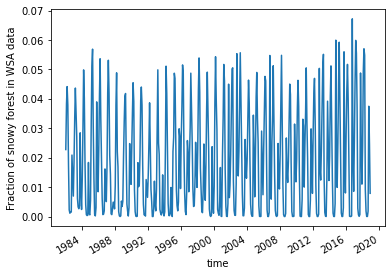

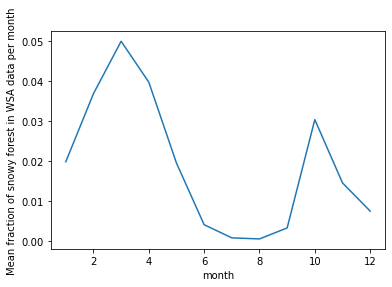

In [96]:
#What fraction of data is snowy forest?
snowforestfraction = np.array(snowforests)/(thisSnow.where(thisSnow<7).count().values)
snowforestfraction_xr = xr.DataArray(snowforestfraction, coords={'time':WSA_EASE2_all.time}, dims='time')

snowforestfraction_xr.plot()
plt.ylabel('Fraction of snowy forest in WSA data')
plt.show()

snowforestfraction_xr.groupby(snowforestfraction_xr.time.dt.month).mean().plot()
plt.ylabel('Mean fraction of snowy forest in WSA data per month')
plt.show()

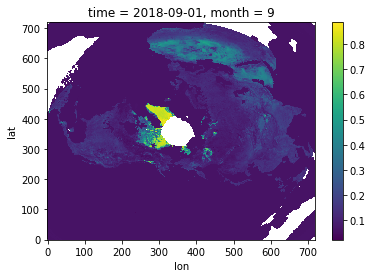

In [134]:
WSA_EASE2_all[-4,:,:].plot()

In [138]:
WSA_EASE2_all.to_netcdf(prod_data_dir + '/C2_SAL_WSA_all_NH_1982_2018.nc')

## SH, only Antarctic snow, sea ice and open water included

In [91]:
snowicecover_SH = xr.open_dataarray(prod_data_dir + '/G02202_Antarctic_seaice_full_1978_2018_v2.nc').sel(time=slice(str(startyear), str(stopyear)))

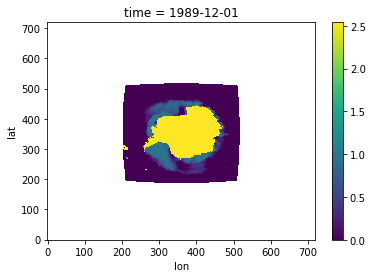

In [92]:
snowicecover_SH.sel(time='1989-12-01').plot()

In [94]:
WSA_EASE2_all_SH = xr.where(snowicecover_SH>0, WSA_SNOW_SH, OSA_SH)
WSA_EASE2_all_SH = xr.where((np.isnan(WSA_EASE2_all_SH)) & (snowicecover_SH<=0), OSA_SH, WSA_EASE2_all_SH)
#WSA_EASE2_all_SH = xr.where(np.isnan(WSA_EASE2_all_SH), WSA_VEG_SH, WSA_EASE2_all_SH)


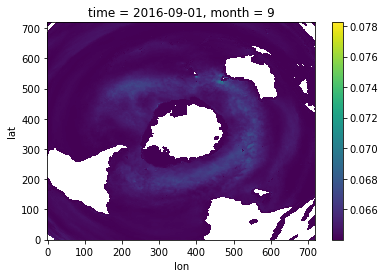

In [95]:
OSA_SH.sel(time='2016-09-01').plot()

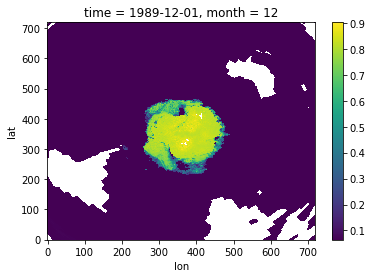

In [96]:
WSA_EASE2_all_SH.sel(time='1989-12-01').plot()

In [97]:
WSA_EASE2_all_SH.to_netcdf(prod_data_dir + '/C2_SAL_WSA_all_SH_1982_2018_v3.nc')

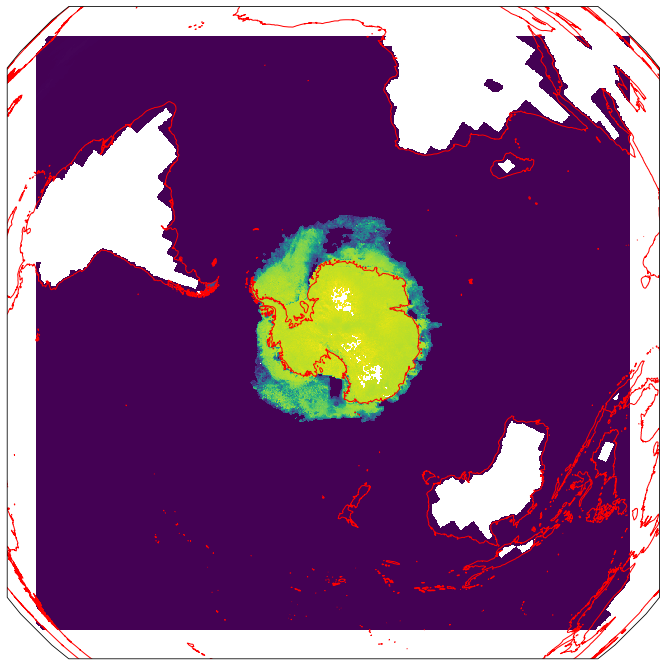

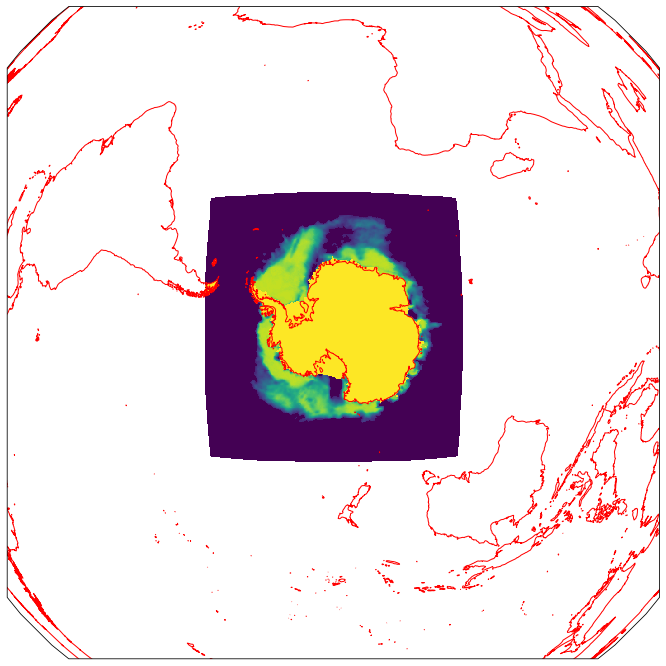

In [98]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(WSA_EASE2_all_SH.longitude, WSA_EASE2_all_SH.latitude,\
               WSA_EASE2_all_SH.sel(time='1989-12-01').values, transform=ccrs.PlateCarree())
ax.coastlines('50m', color='r')
ax.grid()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=-90))
plt.pcolormesh(snowicecover_SH.longitude, snowicecover_SH.latitude,\
               snowicecover_SH.sel(time='1989-12-01').values, transform=ccrs.PlateCarree(), vmax=1.10)
ax.coastlines('50m', color='r')
ax.grid()
plt.show()